In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

from scipy.spatial import KDTree

import matplotlib.pyplot as plt

Need to think carefully about what distance metric we use.

## Metric 1: IMS

Assess the proportion of records in both the synthetic and holdout data sets that are identical to records in the training data set.

In [2]:
train = pd.read_csv("Data/train_dataset.csv")

In [3]:
X = pd.read_csv("Data/full_dataset.csv")

# generate a set of twenty holdout datasets
holdout_datasets = [X.sample(frac=0.5, replace=True).reset_index(drop=True) for i in range(20)]

Perform two-sample bootstrap calculation for the privacy metrics, i.e., we pair synthetic and holdout data sets and treat these as paired bootstrap samples from the population data set. Then we can calculate the mean of each privacy metric and the 95% confidence interval of the metric.

Pick an arbitrary $\delta$ value.

In [4]:
delta = 0.001

Function to calculate the privacy metrics given training, holdout, and synthetic data, for a given delta value.

In [5]:
def privacy_metrics(train_data, holdout_data, synthetic_data, delta):
    
    # synthetic_data["age"] = synthetic_data["age"].astype('category')
    
    # age_dummies = pd.get_dummies(synthetic_data['age'], drop_first=True)
    
    # age_dummies.columns = [str(x) for x in age_dummies.columns]
    
    # synthetic_data = synthetic_data.drop("age", axis=1)
    
    # synthetic_data = pd.concat([synthetic_data, age_dummies], axis=1)
    
    # missing = train_data.columns[[x not in synthetic_data.columns for x in train_data.columns]]
    
    # if len(missing) > 0:
        # for m in missing:
            # new = pd.Series(np.zeros(synthetic_data.shape[0]))
            # new.name = m
            # synthetic_data = pd.concat([synthetic_data, new], axis=1)
            
    # print(synthetic_data)
    
    # print(training.columns[train_data.columns is in synthetic_data.columns])
    
    ###########################################
    
    scaler = StandardScaler()
    
    train_data_scaled = scaler.fit_transform(X=train_data) ####
    
    training_tree = KDTree(train_data_scaled)
    
    holdout_data_scaled = scaler.fit(X=train_data).transform(X=holdout_data) ####
    
    synthetic_data_scaled = scaler.fit(X=train_data).transform(X=synthetic_data) ####
    
    holdout_dists, holdout_neighbors = training_tree.query(x=holdout_data_scaled, k=5, p=2) ####
    
    synthetic_dists, synthetic_neighbors = training_tree.query(x=synthetic_data_scaled, k=5, p=2) ####
    
    IMS_holdout = np.mean(holdout_dists[:,0] <= delta)
    
    IMS_synthetic = np.mean(synthetic_dists[:,0] <= delta)
    
    DCR_holdout = np.percentile(holdout_dists[:,0], q=5)
    
    DCR_synthetic = np.percentile(synthetic_dists[:,0], q=5)
    
    ratios_synthetic = synthetic_dists[:,0]/synthetic_dists[:,-1]
    
    ratios_holdout = holdout_dists[:,0]/holdout_dists[:,-1]
    
    ratios_holdout = np.nan_to_num(ratios_holdout, nan=1.0)
    
    NNDR_synthetic = np.percentile(ratios_synthetic, q=5)
    
    NNDR_holdout = np.percentile(ratios_holdout, q=5)
    
    return ({"IMS_holdout": IMS_holdout, "IMS_synthetic": IMS_synthetic,
             "DCR_holdout": DCR_holdout, "DCR_synthetic": DCR_synthetic,
             "NNDR_holdout": NNDR_holdout, "NNDR_synthetic": NNDR_synthetic})

In [6]:
# sXs_logit_ks = [pd.read_csv("Data/synthetic_datasets/logistic_logistic_ks_" + str(i) + ".csv") for i in range(20)]
sXs_logit_pmse = [pd.read_csv("Data/synthetic_datasets/logistic_logistic_pmse_" + str(i) + ".csv") for i in range(20)]
sXs_logit_inf_pmse = [pd.read_csv("Data/synthetic_datasets/logistic_logistic_inf_pmse_" + str(i) + ".csv") for i in range(20)]
# sXs_cart_ks = [pd.read_csv("Data/synthetic_datasets/cart_logistic_ks_" + str(i) + ".csv") for i in range(20)]
# sXs_cart_pmse = [pd.read_csv("Data/synthetic_datasets/cart_logistic_pmse_" + str(i) + ".csv") for i in range(20)]
# sXs_cart_mb_ks = [pd.read_csv("Data/synthetic_datasets/cart_mb_logistic_ks_" + str(i) + ".csv") for i in range(20)]
sXs_cart_mb_pmse = [pd.read_csv("Data/synthetic_datasets/cart_mb_logistic_pmse_" + str(i) + ".csv") for i in range(20)]
sXs_cart_mb_inf_pmse = [pd.read_csv("Data/synthetic_datasets/cart_mb_inf_logistic_pmse_" + str(i) + ".csv") for i in range(20)]

In [7]:
sXs_mostly = [pd.read_csv("Data/synthetic_datasets/mostly_" + str(i) + ".csv") for i in range(20)]

In [8]:
def mean_privacy_diffs(training_data, holdout_datasets, synthetic_datasets, delta):
    
    metric_list = [privacy_metrics(training_data, holdout_datasets[i], Y, delta=delta) for i,Y in enumerate(synthetic_datasets)]
    
    return {"DCR Diff (Synthetic - Holdout)": np.round(np.mean([x['DCR_synthetic'] for x in metric_list]) - np.mean([x['DCR_holdout'] for x in metric_list]), 4),
            "NNDR Diff (Synthetic - Holdout)": np.round(np.mean([x['NNDR_synthetic'] for x in metric_list]) - np.mean([x['NNDR_holdout'] for x in metric_list]), 4)}

In [9]:
temp = [sXs_logit_pmse, sXs_logit_inf_pmse, sXs_cart_mb_pmse, sXs_cart_mb_inf_pmse, sXs_mostly]

[mean_privacy_diffs(train, holdout_datasets, x, delta) for x in temp]

C:\Users\camer\AppData\Local\Temp\ipykernel_2100\3667416415.py:51: RuntimeWarning: invalid value encountered in divide
  ratios_holdout = holdout_dists[:,0]/holdout_dists[:,-1]
C:\Users\camer\AppData\Local\Temp\ipykernel_2100\3667416415.py:51: RuntimeWarning: invalid value encountered in divide
  ratios_holdout = holdout_dists[:,0]/holdout_dists[:,-1]
C:\Users\camer\AppData\Local\Temp\ipykernel_2100\3667416415.py:51: RuntimeWarning: invalid value encountered in divide
  ratios_holdout = holdout_dists[:,0]/holdout_dists[:,-1]
C:\Users\camer\AppData\Local\Temp\ipykernel_2100\3667416415.py:51: RuntimeWarning: invalid value encountered in divide
  ratios_holdout = holdout_dists[:,0]/holdout_dists[:,-1]
C:\Users\camer\AppData\Local\Temp\ipykernel_2100\3667416415.py:51: RuntimeWarning: invalid value encountered in divide
  ratios_holdout = holdout_dists[:,0]/holdout_dists[:,-1]
C:\Users\camer\AppData\Local\Temp\ipykernel_2100\3667416415.py:51: RuntimeWarning: invalid value encountered in div

C:\Users\camer\AppData\Local\Temp\ipykernel_2100\3667416415.py:51: RuntimeWarning: invalid value encountered in divide
  ratios_holdout = holdout_dists[:,0]/holdout_dists[:,-1]
C:\Users\camer\AppData\Local\Temp\ipykernel_2100\3667416415.py:51: RuntimeWarning: invalid value encountered in divide
  ratios_holdout = holdout_dists[:,0]/holdout_dists[:,-1]
C:\Users\camer\AppData\Local\Temp\ipykernel_2100\3667416415.py:51: RuntimeWarning: invalid value encountered in divide
  ratios_holdout = holdout_dists[:,0]/holdout_dists[:,-1]
C:\Users\camer\AppData\Local\Temp\ipykernel_2100\3667416415.py:51: RuntimeWarning: invalid value encountered in divide
  ratios_holdout = holdout_dists[:,0]/holdout_dists[:,-1]
C:\Users\camer\AppData\Local\Temp\ipykernel_2100\3667416415.py:51: RuntimeWarning: invalid value encountered in divide
  ratios_holdout = holdout_dists[:,0]/holdout_dists[:,-1]
C:\Users\camer\AppData\Local\Temp\ipykernel_2100\3667416415.py:51: RuntimeWarning: invalid value encountered in div

[{'DCR Diff (Synthetic - Holdout)': 0.0006,
  'NNDR Diff (Synthetic - Holdout)': 0.0145},
 {'DCR Diff (Synthetic - Holdout)': 0.0006,
  'NNDR Diff (Synthetic - Holdout)': 0.0137},
 {'DCR Diff (Synthetic - Holdout)': 0.0005,
  'NNDR Diff (Synthetic - Holdout)': 0.0081},
 {'DCR Diff (Synthetic - Holdout)': 0.0005,
  'NNDR Diff (Synthetic - Holdout)': 0.0079},
 {'DCR Diff (Synthetic - Holdout)': 0.0,
  'NNDR Diff (Synthetic - Holdout)': 0.0265}]

***

Examine how IMS diff changes with $\delta$

In [10]:
def ims_range(train_data, synthetic_data, delta):
    
    ###########################################
    
    scaler = StandardScaler()
    
    train_data_scaled = scaler.fit_transform(X=train_data) ####
    
    training_tree = KDTree(train_data_scaled)
    
    synthetic_data_scaled = scaler.fit(X=train_data).transform(X=synthetic_data) ####
    
    synthetic_dists, synthetic_neighbors = training_tree.query(x=synthetic_data_scaled, k=5, p=2) ####
    
    IMS_synthetic = np.mean(synthetic_dists[:,0] <= delta)
    
    return IMS_synthetic

In [11]:
def ims_apply(train_data, synthetic_data_sets, delta_vals):
    ims = [[ims_range(train_data=train_data, synthetic_data=y, delta=x) for x in delta_vals] for y in synthetic_data_sets]
    avg_ims = np.mean(np.vstack(ims), axis=0)
    return avg_ims

In [12]:
delta_vals = np.linspace(0.00001, 1.0, 20)

In [13]:
avg_holdout_ims = ims_apply(train, holdout_datasets, delta_vals)
avg_cart_ims = ims_apply(train, sXs_cart_mb_pmse, delta_vals)
avg_cart_inf_ims = ims_apply(train, sXs_cart_mb_inf_pmse, delta_vals)
avg_mnl_ims = ims_apply(train, sXs_logit_pmse, delta_vals)
avg_mnl_inf_ims = ims_apply(train, sXs_logit_inf_pmse, delta_vals)
avg_mostly_ims = ims_apply(train, sXs_mostly, delta_vals)

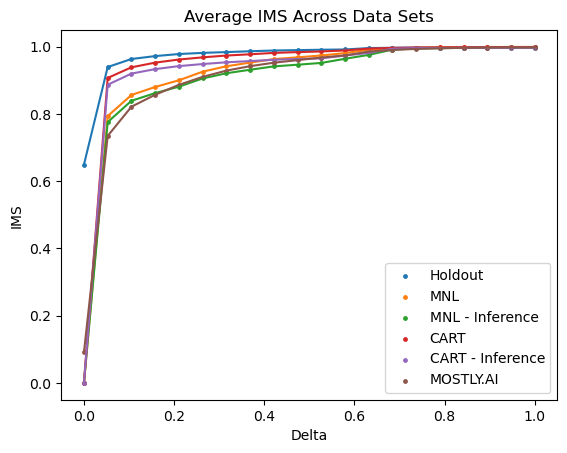

In [14]:
plt.plot(delta_vals, avg_holdout_ims)
plt.scatter(delta_vals, avg_holdout_ims, s=6, label="Holdout")

plt.plot(delta_vals, avg_mnl_ims)
plt.scatter(delta_vals, avg_mnl_ims, s=6, label="MNL")

plt.plot(delta_vals, avg_mnl_inf_ims)
plt.scatter(delta_vals, avg_mnl_inf_ims, s=6, label="MNL - Inference")

plt.plot(delta_vals, avg_cart_ims)
plt.scatter(delta_vals, avg_cart_ims, s=6, label="CART")

plt.plot(delta_vals, avg_cart_inf_ims)
plt.scatter(delta_vals, avg_cart_inf_ims, s=6, label="CART - Inference")

plt.plot(delta_vals, avg_mostly_ims)
plt.scatter(delta_vals, avg_mostly_ims, s=6, label="MOSTLY.AI")

plt.title("Average IMS Across Data Sets")
plt.xlabel("Delta")
plt.ylabel("IMS")

plt.legend()
plt.show()

***

Assess attribute disclosure for disease status.

Let's start with the adversary's prior. As of March 23, 2020, their were 9583 confirmed COVID-19 cases and 152 deaths. 

https://covid19.who.int/region/wpro/country/kr

These statistics could be collected from the World Health Organization, and would represent a much more informative prior than a naive uniform prior. Furthermore, evaluating the naive prior would create problems when trying to prevent inference on individuals who did not pass away from COVID.

In [15]:
prior_death_prob = 152/9583

In [16]:
def inference_evaluation(original_data, synthetic_data, prior_prob, deltas):
    
    full_inf_conds = []
    full_indices = []
    
    # tree for original locations
    orig_tree = KDTree(original_data[["latitude", "longitude"]])
    
    # tree for synthetic locations
    sX_tree = KDTree(synthetic_data[["latitude", "longitude"]])
    
    for d in deltas:
        
        # lists to store the inference condition for each original row and the indices of those rows that violate
        inf_conds = []
    
        # find synthetic neighbors of each original point
        location_neighbors = orig_tree.query_ball_tree(sX_tree, r=d, p=2.0)
    
        # for each original record
        for i,row in original_data.iterrows():
        
            # matches on categorical attributes from location neighbors
            categorical_matches = (synthetic_data.loc[location_neighbors[i],['sex', 'age']] == row[['sex', 'age']]).all(1)
            
            matching_rows = synthetic_data.loc[location_neighbors[i],:].loc[categorical_matches.values,:]
            
            if matching_rows.shape[0] > 0:
                
                if row['state'] == 1.0:
                    prior = prior_prob
                else:
                    prior = 1 - prior_prob
            
                cond = np.mean(matching_rows['state'] == row['state'])/prior
                
            else:
                
                cond = 1
        
            # store number of matches and their indices
            inf_conds.append(cond)
        
        inf_conds = pd.Series(inf_conds)
        
        full_inf_conds.append(inf_conds)
        
    print("Dataset completed.")
        
    return full_inf_conds

In [17]:
holdout_inf = [inference_evaluation(train, Y, prior_death_prob, delta_vals) for Y in holdout_datasets]
holdout_inf = [pd.concat(x, axis=1) for x in holdout_inf]

Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.


In [18]:
for i in range(20):
    holdout_inf[i].to_csv("Data/privacy_results/holdout_inf_" + str(i) + ".csv", index=False)
holdout_inf = [pd.read_csv("Data/privacy_results/holdout_inf_" + str(i) + ".csv") for i in range(20)]

In [19]:
mnl_inf = [inference_evaluation(train, Y, prior_death_prob, delta_vals) for Y in sXs_logit_pmse]
mnl_inf = [pd.concat(x, axis=1) for x in mnl_inf]

Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.


In [20]:
for i in range(20):
    mnl_inf[i].to_csv("Data/privacy_results/mnl_inf_" + str(i) + ".csv", index=False)
mnl_inf = [pd.read_csv("Data/privacy_results/mnl_inf_" + str(i) + ".csv") for i in range(20)]

In [21]:
mnl_inf_prev = [inference_evaluation(train, Y, prior_death_prob, delta_vals) for Y in sXs_logit_inf_pmse]
mnl_inf_prev = [pd.concat(x, axis=1) for x in mnl_inf_prev]

Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.


In [22]:
for i in range(20):
    mnl_inf_prev[i].to_csv("Data/privacy_results/mnl_inf_prev_" + str(i) + ".csv", index=False)
mnl_inf_prev = [pd.read_csv("Data/privacy_results/mnl_inf_prev_" + str(i) + ".csv") for i in range(20)]

In [23]:
cart_inf = [inference_evaluation(train, Y, prior_death_prob, delta_vals) for Y in sXs_cart_mb_pmse]
cart_inf = [pd.concat(x, axis=1) for x in cart_inf]

Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.


In [24]:
for i in range(20):
    cart_inf[i].to_csv("Data/privacy_results/cart_inf_" + str(i) + ".csv", index=False)
cart_inf = [pd.read_csv("Data/privacy_results/cart_inf_" + str(i) + ".csv") for i in range(20)]

In [25]:
cart_inf_prev = [inference_evaluation(train, Y, prior_death_prob, delta_vals) for Y in sXs_cart_mb_inf_pmse]
cart_inf_prev = [pd.concat(x, axis=1) for x in cart_inf_prev]

Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.


In [26]:
for i in range(20):
    cart_inf_prev[i].to_csv("Data/privacy_results/cart_inf_prev_" + str(i) + ".csv", index=False)
cart_inf_prev = [pd.read_csv("Data/privacy_results/cart_inf_prev_" + str(i) + ".csv") for i in range(20)]

In [27]:
mostly_inf = [inference_evaluation(train, Y, prior_death_prob, delta_vals) for Y in sXs_mostly]
mostly_inf = [pd.concat(x, axis=1) for x in mostly_inf]

Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.
Dataset completed.


In [28]:
for i in range(20):
    mostly_inf[i].to_csv("Data/privacy_results/mostly_inf_" + str(i) + ".csv", index=False)
mostly_inf = [pd.read_csv("Data/privacy_results/mostly_inf_" + str(i) + ".csv") for i in range(20)]

Need to calculate the maximum increase in inference in each data set.

In [29]:
max_holdout_inf = [np.max(x, axis=0) for x in holdout_inf]
max_mnl_inf = [np.max(x, axis=0) for x in mnl_inf]
max_mnl_inf_prev = [np.max(x, axis=0) for x in mnl_inf_prev]
max_cart_inf = [np.max(x, axis=0) for x in cart_inf]
max_cart_inf_prev = [np.max(x, axis=0) for x in cart_inf_prev]
max_mostly_inf = [np.max(x, axis=0) for x in mostly_inf]

Could look at the distribution of the maximum increase for each data set.

In [30]:
avg_max_holdout = np.mean(pd.concat(max_holdout_inf, axis=1), axis=1)
avg_max_mnl = np.mean(pd.concat(max_mnl_inf, axis=1), axis=1)
avg_max_mnl_prev = np.mean(pd.concat(max_mnl_inf_prev, axis=1), axis=1)
avg_max_cart = np.mean(pd.concat(max_cart_inf, axis=1), axis=1)
avg_max_cart_prev = np.mean(pd.concat(max_cart_inf_prev, axis=1), axis=1)
avg_max_mostly = np.mean(pd.concat(max_mostly_inf, axis=1), axis=1)

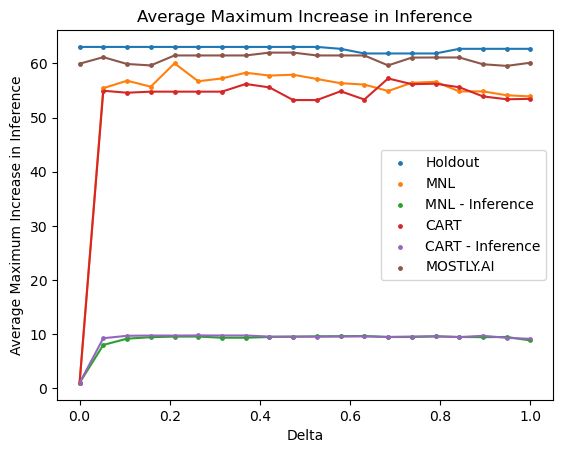

In [31]:
plt.plot(delta_vals, avg_max_holdout)
plt.scatter(delta_vals, avg_max_holdout, s=6, label="Holdout")

plt.plot(delta_vals, avg_max_mnl)
plt.scatter(delta_vals, avg_max_mnl, s=6, label="MNL")

plt.plot(delta_vals, avg_max_mnl_prev)
plt.scatter(delta_vals, avg_max_mnl_prev, s=6, label="MNL - Inference")

plt.plot(delta_vals, avg_max_cart)
plt.scatter(delta_vals, avg_max_cart, s=6, label="CART")

plt.plot(delta_vals, avg_max_cart_prev)
plt.scatter(delta_vals, avg_max_cart_prev, s=6, label="CART - Inference")

plt.plot(delta_vals, avg_max_mostly)
plt.scatter(delta_vals, avg_max_mostly, s=6, label="MOSTLY.AI")

plt.title("Average Maximum Increase in Inference")
plt.xlabel("Delta")
plt.ylabel("Average Maximum Increase in Inference")

plt.legend()
plt.show()